In [1]:
!git clone https://github.com/KORALLLL/diffusion.git
!pip install torcheval

Cloning into 'diffusion'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 258 (delta 140), reused 188 (delta 74), pack-reused 0 (from 0)
Receiving objects: 100% (258/258), 2.94 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (140/140), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.0 MB/s eta 0:00:00a 0:00:01


In [2]:
import pickle, gzip, math, os,sys, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc, random
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from fastcore.test import test_close
import logging



sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('/kaggle/working/diffusion'))


from diffusion.data_utils import *
from diffusion.learners import *
from diffusion.callbacks import *
from diffusion.metrics import *
from diffusion.utils import *
from diffusion.modules import *

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)

set_seed(42)

In [5]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32, 32)) for o in b[x]]

In [7]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

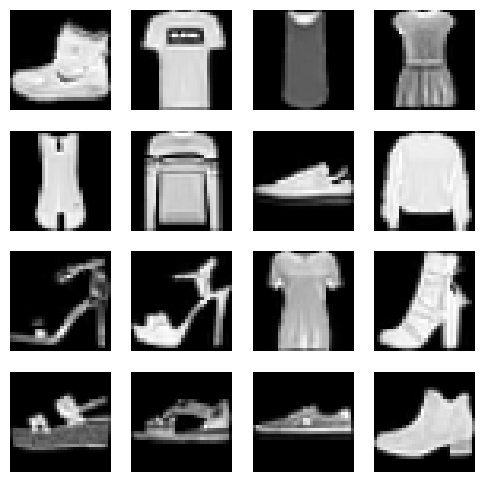

In [7]:
show_images(xb[:16], imsize=1.5)

In [8]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

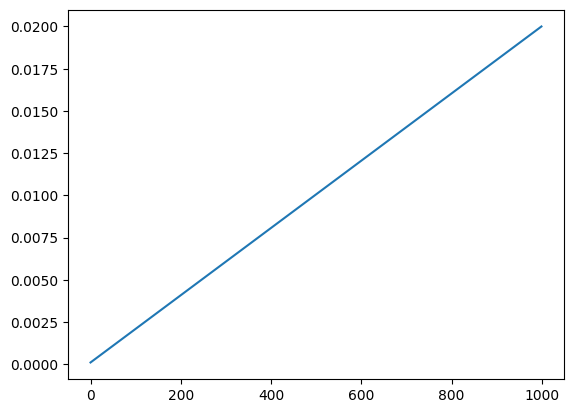

In [9]:
plt.plot(beta)

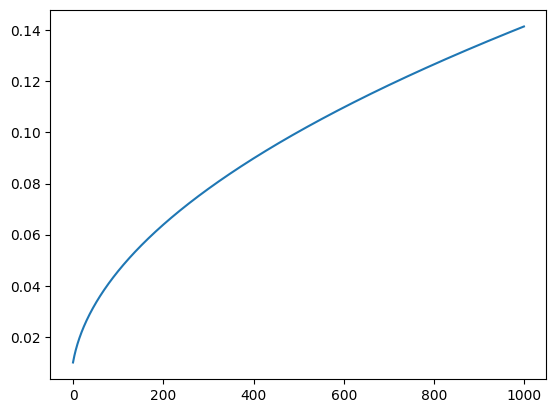

In [10]:
plt.plot(sigma)

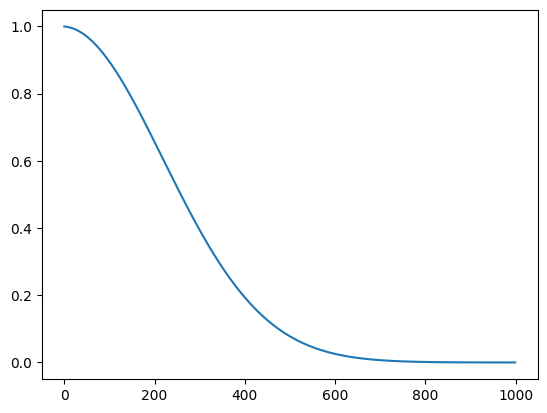

In [11]:
plt.plot(alphabar)

# Creation of model

In [12]:
!pip install diffusers
from diffusers import UNet2DModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.3 MB/s eta 0:00:0000:0100:01


2024-08-18 14:43:43.728684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 14:43:43.728821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 14:43:43.860893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
#export
from tqdm.notebook import tqdm
class DDPMCB(TrainCB):
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps, self.beta_min, self.beta_max = n_steps, beta_min, beta_max
        self.beta = torch.linspace(self.beta_min, self.beta_max, n_steps)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()
        
    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample
        
    def before_batch(self, learn):
        device = learn.batch[0].device
        epsilon = torch.randn(learn.batch[0].shape, device=device)
        x_0 = learn.batch[0] # oroginal images
        self.alpha_bar = self.alpha_bar.to(device)
        n = x_0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        alpha_bar_t = self.alpha_bar[t].reshape(-1, 1, 1,1).to(device)
        x_t = alpha_bar_t.sqrt() * x_0 + (1 - alpha_bar_t).sqrt() * epsilon
        #input to model is noist image and timestamp, ground truth is the noise
        learn.batch = ((x_t, t), epsilon)
        
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.rand(sz, device = device)
        preds = []
        for t in tqdm(reversed(range(self.n_steps)), leave=False):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            alpha_bar_t1 = self.alpha_bar[t-1] if t > 0 else torch.tensor(1)
            beta_bar_t = 1 - self.alpha_bar[t]
            beta_bar_t1 = 1 - alpha_bar_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - beta_bar_t.sqrt() * noise_pred) / self.alpha_bar[t].sqrt()).clamp(-1,1)
            x_0_coeff = alpha_bar_t1.sqrt() * (1 - self.alpha[t]) / beta_bar_t
            x_t_coeff = self.alpha[t].sqrt() * beta_bar_t1 / beta_bar_t
            x_t = x_0_hat * x_0_coeff + x_t * x_t_coeff + self.sigma[t] * z
            preds.append(x_t.cpu())
        return preds

In [14]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128)).to('cuda:0')

In [16]:
torch.use_deterministic_algorithms(False)
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(device='cuda:0'), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.052,0,True
0.022,0,False
0.020,1,True
0.018,1,False


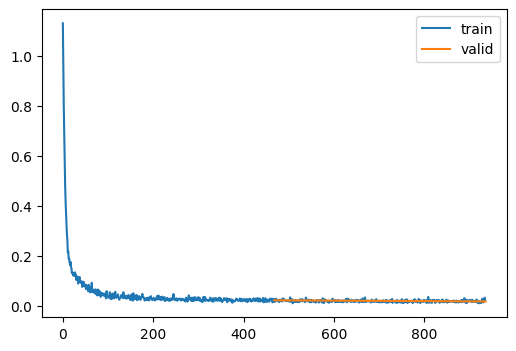

In [17]:
learn.fit(2)

# inference

In [18]:
set_seed(42)
torch.use_deterministic_algorithms(False)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

0it [00:00, ?it/s]

1000

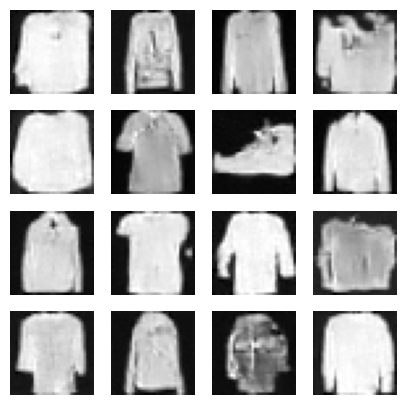

In [19]:
show_images(samples[-1], figsize=(5,5))

In [25]:
%matplotlib auto
from fastcore.foundation import L
import matplotlib.animation as animation
from IPython.display import display, HTML

fig, ax = plt.subplots(figsize=(3,3))
def _show(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(0, 600, 50) + L.range(600, 880, 10) + L.range(800, 990, 5) + L.range(990, 1000) + [999] * 10
ims = r.map(_show)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Using matplotlib backend: agg


# Alternate approach

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
dt = dls.train
xb,yb = next(iter(dt))

In [7]:
def noisify(x_0, alpha_bar):
    device = x_0.device
    n = len(x_0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    epsilon = torch.randn(x_0.shape, device=device)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alpha_bar_t.sqrt()*x_0 + (1-alpha_bar_t).sqrt()*epsilon
    return (xt, t.to(device)), epsilon

In [8]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [9]:
(x_t,t),epsilon = noisify(xb[:25],alphabar)
t

tensor([876, 414,  26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295, 567, 706, 749, 876,  73, 111, 899, 213, 541])

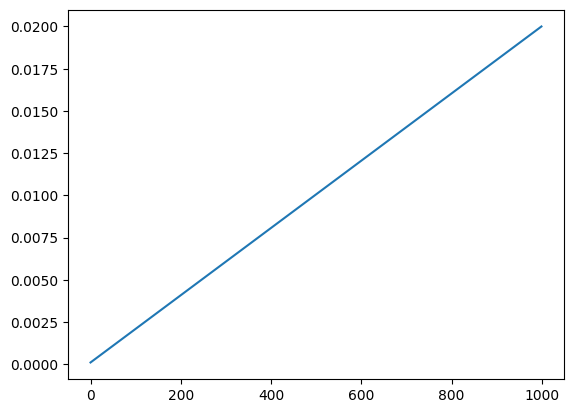

In [10]:
plt.plot(beta)

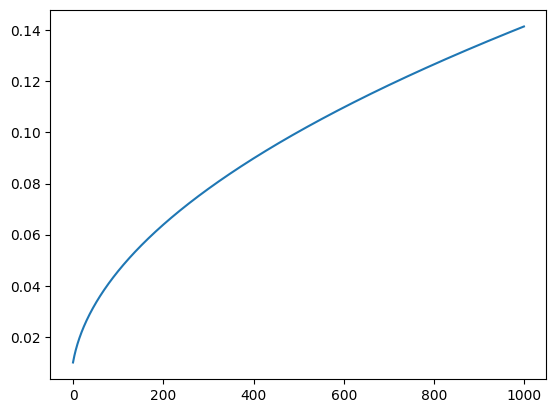

In [11]:
plt.plot(sigma)

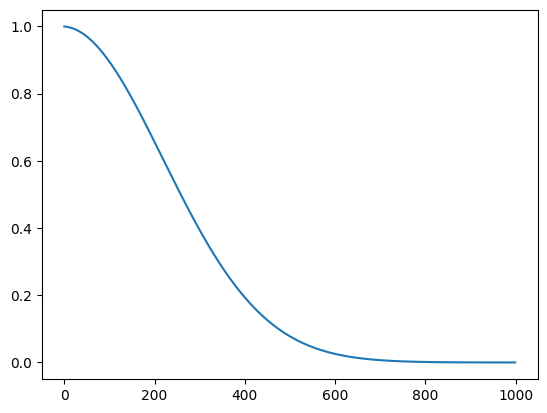

In [12]:
plt.plot(alphabar);

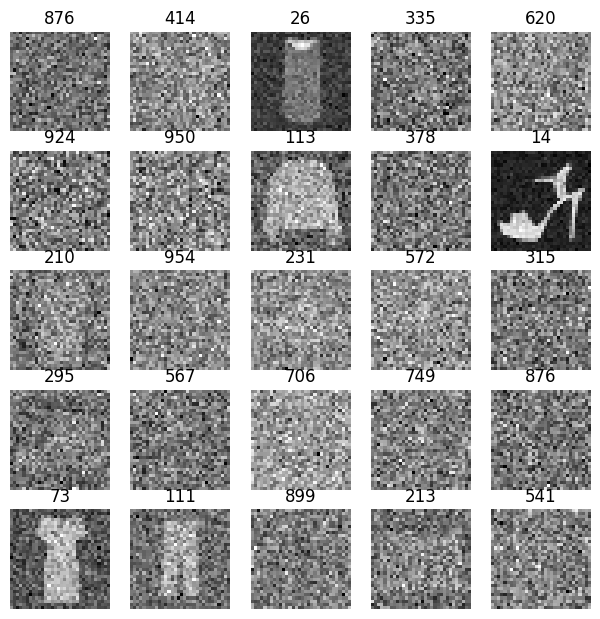

In [13]:
titles = fc.map_ex(t, '{}')
show_images(x_t, imsize=1.5, titles=titles)

# Training

In [14]:
!pip install diffusers
from diffusers import UNet2DModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.6 MB/s eta 0:00:00a 0:00:01


2024-08-18 17:09:28.303310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 17:09:28.303418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 17:09:28.445525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alpha_bar_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        beta_bar_t = 1 - alphabar[t]
        beta_bar_t1 = 1 - alpha_bar_t1
        x_0_hat = ((x_t - beta_bar_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * alpha_bar_t1.sqrt()*(1-alpha[t])/beta_bar_t + x_t * alpha[t].sqrt()*beta_bar_t1/beta_bar_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [16]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1. - self.beta 
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.alpha_bar)
    def sample(self, model, sz): return sample(model, sz, self.alpha, self.alpha_bar, self.sigma, self.n_steps)

In [17]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [18]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

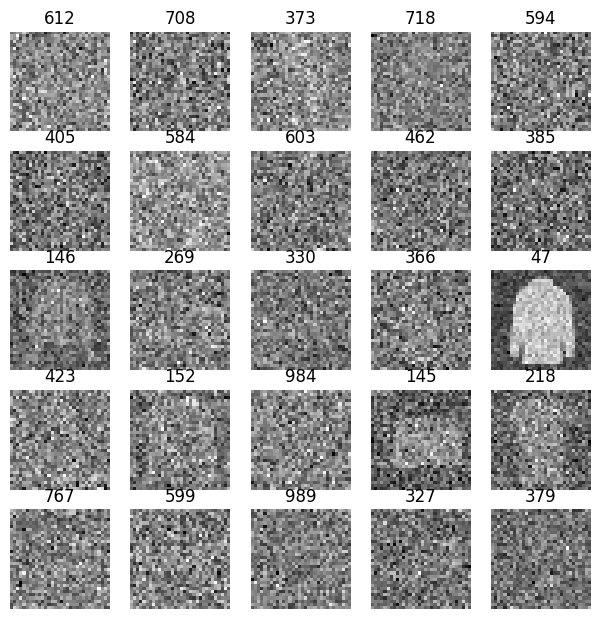

In [19]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
try: learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
except: pass
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [20]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(device='cuda:0'), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [21]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [22]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [23]:
init_ddpm(model)

In [24]:
opt_func = partial(optim.Adam, eps=1e-5)

In [25]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.146,0,True
0.026,0,False
0.021,1,True
0.020,1,False
0.019,2,True
0.018,2,False
0.017,3,True
0.016,3,False
0.016,4,True
0.016,4,False


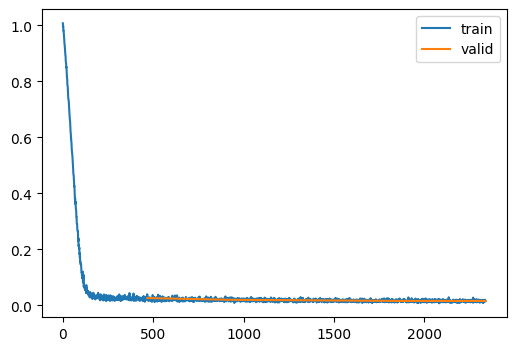

In [36]:
torch.use_deterministic_algorithms(False)
learn.fit(epochs)

# sampling

In [37]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

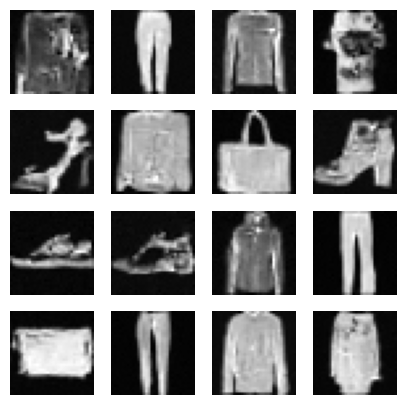

In [38]:
show_images(samples[-1], figsize=(5,5))

# mixed precision

In [28]:
bs = 512

In [29]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [30]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [31]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [32]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [41]:
clean_mem()
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(device='cuda:0'), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.222,0,True
0.033,0,False
0.027,1,True
0.025,1,False
0.022,2,True
0.022,2,False
0.021,3,True
0.021,3,False


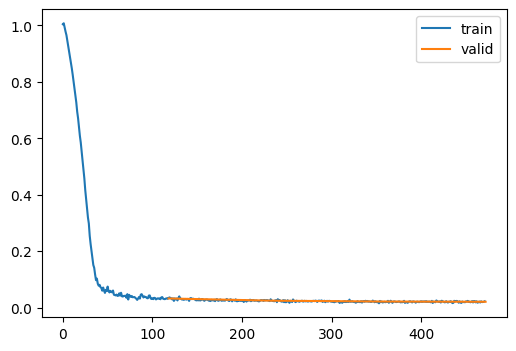

ValueError: Tried to step 945 times. The specified number of total steps is 944

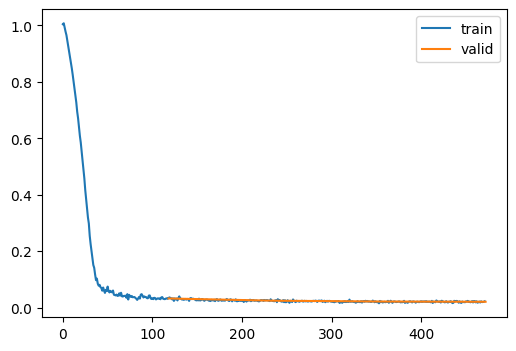

In [42]:
# torch.use_deterministic_algorithms(False)

learn.fit(epochs)

# Accelerate

In [43]:
!pip install accelerate
from accelerate import Accelerator

In [44]:
class AccelerateCB(TrainCB):
    order = DeviceCB.order + 10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
    def before_fit(self, learn):
        learn.model, learn.opt, learn.dls.train, learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    def backward(self, learn): self.acc.backward(learn.loss)

In [45]:
def noisify(x_0, alpha_bar):
    device = x_0.device
    n = len(x_0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    epsilon = torch.randn(x_0.shape, device=device)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alpha_bar_t.sqrt()*x_0 + (1-alpha_bar_t).sqrt()*epsilon
    return xt, t.to(device), epsilon

In [46]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test'])) 

In [47]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [57]:
clean_mem()
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(device='cuda:0'), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.221,0,True
0.051,0,False
0.028,1,True
0.025,1,False
0.023,2,True
0.021,2,False
0.021,3,True
0.020,3,False


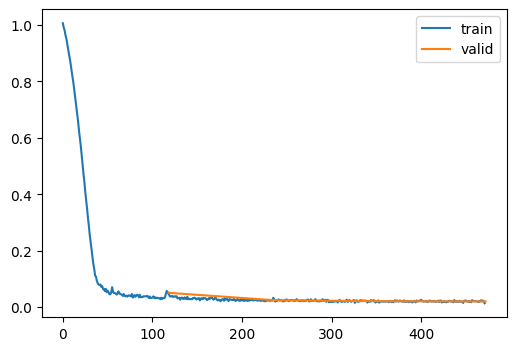

ValueError: Tried to step 945 times. The specified number of total steps is 944

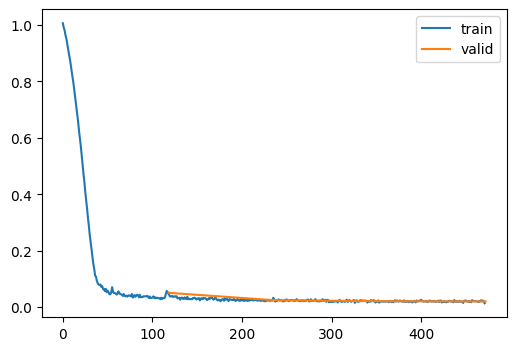

In [58]:
learn.fit(epochs)

# A sneaky trick

In [59]:
class MultDL:
    def __init__(self, dl, mult=2): self.dl, self.mult = dl, mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o

In [60]:
dls.train = MultDL(dls.train)